In [1]:
%load_ext autoreload
%autoreload 2

import pyVHR as vhr
import numpy as np
from pyVHR.analysis.pipeline import Pipeline
from pyVHR.plot.visualize import *
import os
import plotly.express as px
from pyVHR.utils.errors import getErrors, printErrors, displayErrors

import constants
import pandas as pd
import pyVHR.analysis.pipelineLandmarks as custom_pipeline

vhr.plot.VisualizeParams.renderer = 'vscode' 

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
import configparser
import ast
from numpy.lib.arraysetops import isin
import pandas as pd
import numpy as np
import time
from importlib import import_module, util
from pyVHR.datasets.dataset import datasetFactory
from pyVHR.utils.errors import getErrors, printErrors, displayErrors, BVP_windowing
from pyVHR.extraction.sig_processing import *
from pyVHR.extraction.sig_extraction_methods import *
from pyVHR.extraction.skin_extraction_methods import *
from pyVHR.BVP.BVP import *
from pyVHR.BPM.BPM import *
from pyVHR.BVP.methods import *
from pyVHR.BVP.filters import *
from inspect import getmembers, isfunction
import os.path
from pyVHR.deepRPPG.mtts_can import *
from pyVHR.deepRPPG.hr_cnn import *
from pyVHR.extraction.utils import *
from dtw import *
from scipy import signal
import scipy
import time
import steps

from tqdm import tqdm
from PIL import Image, ImageStat

In [3]:
# -- LOAD A DATASET

dataset_name = 'mr_nirp' 
winsize = 8        # seconds of video processed (with overlapping) for each estimate   

video_DIR, BVP_DIR = constants.get_dataset_paths(dataset_name)
videoFPS, sigFPS = constants.get_fps(dataset_name)
print(f"Video fps for {dataset_name} is {videoFPS}, Signal fps is {sigFPS} ")

dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames
videos = constants.get_video_settings(dataset_name)
print(videos)

# print the list of video names with the progressive index (idx)
for v in range(len(allvideo)):
  print(v, allvideo[v])

Video fps for mr_nirp is 30, Signal fps is 60 
{'MOTION': [0, 2, 4, 6, 9, 11, 13], 'STILL': [1, 3, 5, 7, 8, 10, 12, 14], 'MALE': [0, 1, 4, 5, 6, 7, 8, 9, 10, 13, 14], 'FEMALE': [2, 3, 11, 12], 'BEARD': [0, 1, 4, 5, 8, 9, 10, 13, 14], 'DARK': [0, 1, 2, 3, 4, 5, 13, 14]}
0 D:/datasets_rppg/MR-NIRP_indoor\Subject1_motion_940\Subject1_motion_940\RGB_corrected\Subject1_motion_940.avi
1 D:/datasets_rppg/MR-NIRP_indoor\Subject1_still_940-015\Subject1_still_940\RGB_corrected\Subject1_still_940.avi
2 D:/datasets_rppg/MR-NIRP_indoor\Subject2_motion_940\Subject2_motion_940\RGB_corrected\Subject2_motion_940.avi
3 D:/datasets_rppg/MR-NIRP_indoor\Subject2_still_940-002\Subject2_still_940\RGB_corrected\Subject2_still_940.avi
4 D:/datasets_rppg/MR-NIRP_indoor\Subject3_motion_940\Subject3_motion_940\RGB_corrected\Subject3_motion_940.avi
5 D:/datasets_rppg/MR-NIRP_indoor\Subject3_still_940-012\Subject3_still_940\RGB_corrected\Subject3_still_940.avi
6 D:/datasets_rppg/MR-NIRP_indoor\Subject4_motion_940\S

videoFileName :  D:/datasets_rppg/MR-NIRP_indoor\Subject1_motion_940\Subject1_motion_940\RGB_corrected\Subject1_motion_940.avi
Video frame rate:      30 30.0
Length of the video: 1:05 min, timesGT is 66 s
Signal frame rate is 60 for MR_NIRP and signal is  65.16666666666667 seconds worth


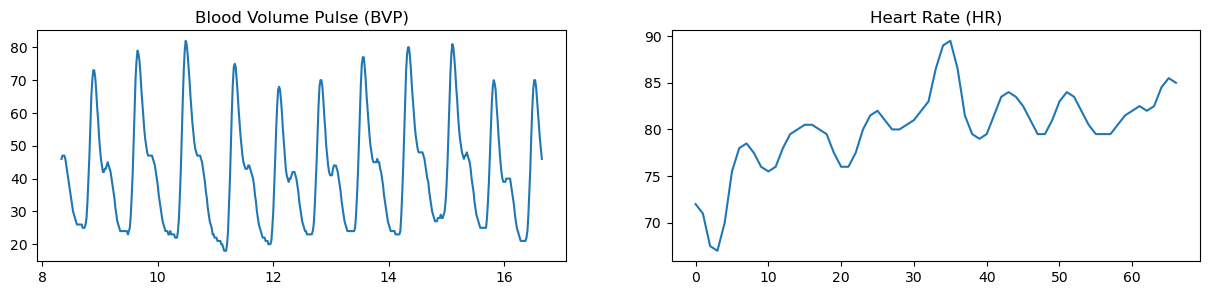

In [4]:
# -- PARAMETER SETTING

videoIdx = 0
fname = dataset.getSigFilename(videoIdx)
videoFileName = dataset.getVideoFilename(videoIdx)
fps = vhr.extraction.get_fps(videoFileName)
sigGT = dataset.readSigfile(fname)
bpmGT, timesGT = sigGT.getBPM(winsize) # STFT 42-240 BPM

print("videoFileName : ", videoFileName)
print('Video frame rate:     ',videoFPS, fps)
print(f"Length of the video: 1:05 min, timesGT is {len(timesGT)-1} s")
print(f"Signal frame rate is {sigFPS} for {dataset_name.upper()} and signal is ", sigGT.data.shape[1] / sigFPS, "seconds worth")

fig, ax = plt.subplots(1,2,figsize=(15,3))
ax[0].plot(np.arange(0, len(timesGT), 1/sigFPS)[500:1000], sigGT.data.T[500:1000])
ax[0].set_title('Blood Volume Pulse (BVP)')
ax[1].plot(timesGT, bpmGT)
ax[1].set_title('Heart Rate (HR)')
plt.show()

# ROI brightness

- Use convex hull method to extract face
- Compute brightness of face 
- Adjust brightness of ROI to match the target face brightness

In [5]:
def get_brightness(frame):
   """
      Convert image to greyscale, return average pixel brightness.
   """
   im =  Image.fromarray(frame).convert('L')
   stat = ImageStat.Stat(im)
   return stat.mean[0]

def change_brightness(img, value=0):
    """
      img: array
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

from matplotlib.path import Path
def sort_coordinates(list_of_xy_coords):
    cx, cy = list_of_xy_coords.mean(0)
    x, y = list_of_xy_coords.T
    angles = np.arctan2(x-cx, y-cy)
    indices = np.argsort(angles)
    return list_of_xy_coords[indices]

def landmarks_path_mean(ldmks, im, sampling_method, nb_sample_points, RGB_LOW_TH, RGB_HIGH_TH, roi_brightness):
    def sort_coordinates(list_of_xy_coords):
        cx, cy = list_of_xy_coords.mean(0)
        x, y = list_of_xy_coords.T
        angles = np.arctan2(x-cx, y-cy)
        indices = np.argsort(angles)
        return list_of_xy_coords[indices]
    
    ldmks = sort_coordinates(ldmks[:,0:2]) # works with (c,r) coordinates
    r_ldmks = np.zeros((1,5), dtype=np.float32)
    lds_mean = np.zeros(3, dtype=np.float32)

    polygon_path = Path(ldmks[:,::-1]) # works with (r,c) coordinates
    top_left = np.min(ldmks, axis=0).astype(int)
    bottom_right = np.max(ldmks, axis=0).astype(int)

    x, y = np.meshgrid(np.arange(top_left[1], bottom_right[1]+1), np.arange(top_left[0], bottom_right[0]+1)) # (c,r)
    x, y = x.flatten(), y.flatten()
    pixel_coordinates = np.vstack((x,y)).T
    grid = polygon_path.contains_points(pixel_coordinates)
    pixel_coordinates = pixel_coordinates[grid][:,::-1] # (r,c)
    if sampling_method == 'all':
        pass
    elif sampling_method == 'random': # randomly sample from pixel_coordinates
        nb_sample_points = min(nb_sample_points, len(pixel_coordinates))
        pixel_coordinates = pixel_coordinates[np.random.choice(len(pixel_coordinates), nb_sample_points, replace=False)]
    # if sampling_method == 'corner':
    #     pixel_coordinates = ldmks.astype(int)
    else:
        raise ValueError('sampling must be either \'all\' or \'random\'', sampling_method)
    pixel_coordinates = np.array(pixel_coordinates)
    num_elems = len(pixel_coordinates)

    if pixel_coordinates.shape[0] != 0:
        pixel_values = im[pixel_coordinates[:,0], pixel_coordinates[:,1]]                    
        brightness = get_brightness(pixel_values)
        target_brightness = roi_brightness
        value = int(target_brightness - brightness)
        brightner_pixel_values = change_brightness(np.expand_dims(pixel_values, axis=0), value=value)
        im[pixel_coordinates[:,0], pixel_coordinates[:,1]] = brightner_pixel_values[0]
    
    for (x,y) in pixel_coordinates:
        if not((im[x, y, 0] <= RGB_LOW_TH and im[x, y, 1] <= RGB_LOW_TH and im[x, y, 2] <= RGB_LOW_TH) or
                (im[x, y, 0] >= RGB_HIGH_TH and im[x, y, 1] >= RGB_HIGH_TH and im[x, y, 2] >= RGB_HIGH_TH)):
            lds_mean[0] += np.float32(im[x, y, 0])
            lds_mean[1] += np.float32(im[x, y, 1])
            lds_mean[2] += np.float32(im[x, y, 2])

    if num_elems > 1.0:
        r_ldmks[:, 2] = lds_mean[0] / num_elems
        r_ldmks[:, 3] = lds_mean[1] / num_elems
        r_ldmks[:, 4] = lds_mean[2] / num_elems
        
    return r_ldmks, pixel_coordinates

def extract_patches(videoFileName, sig_extractor, roi_brightness):
    """
        Etract rppg while brightning
    """

    RGB_LOW_TH = np.int32(SignalProcessingParams.RGB_LOW_TH)
    RGB_HIGH_TH = np.int32(SignalProcessingParams.RGB_HIGH_TH)

    sig_extractor.frame_images = []
    sig_extractor.brightned_images = []

    skin_ex = sig_extractor.skin_extractor

    mp_drawing = mp.solutions.drawing_utils
    mp_face_mesh = mp.solutions.face_mesh
    PRESENCE_THRESHOLD = 0.5
    VISIBILITY_THRESHOLD = 0.5

    sig = []
    processed_frames_count = 0
    sig_extractor.patch_landmarks = []

    with mp_face_mesh.FaceMesh(
            max_num_faces=1,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5) as face_mesh:
        
        for frame in extract_frames_yield(videoFileName):
            # convert the BGR image to RGB.
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            processed_frames_count += 1
            width, height = image.shape[1], image.shape[0]
            brighter_frame = frame.copy()


            ldmks = np.zeros((468, 5), dtype=np.float32)
            ldmks[:, 0] = -1.0
            ldmks[:, 1] = -1.0
            magic_ldmks = []
            ldmk_brightness = {}
            ### face landmarks ###
            results = face_mesh.process(image)
            if results.multi_face_landmarks:
                face_landmarks = results.multi_face_landmarks[0]
                landmarks = [l for l in face_landmarks.landmark] # 468 Mediapipe keypoints
                for idx in range(len(landmarks)):
                    landmark = landmarks[idx]
                    if not ((landmark.HasField('visibility') and landmark.visibility < VISIBILITY_THRESHOLD)
                            or (landmark.HasField('presence') and landmark.presence < PRESENCE_THRESHOLD)):
                        coords = mp_drawing._normalized_to_pixel_coordinates(
                            landmark.x, landmark.y, width, height)
                        if coords:
                            ldmks[idx, 0] = coords[1]
                            ldmks[idx, 1] = coords[0]

                cropped_skin_im, full_skin_im = skin_ex.extract_skin(image, ldmks)

            else:
                full_skin_im = np.zeros_like(image)

            for region in sig_extractor.ldmks:
                keypoints = np.empty((len(region), 5))
                for i,idx in enumerate(region):
                    keypoints[i] = ldmks[idx]
                magic_ldmks.append(keypoints)  # coordinates of selected landmarks keypoints  
            temp = np.empty((len(magic_ldmks),5))
            for i,region in enumerate(magic_ldmks):
                temp[i,:], pixel_coordinates = landmarks_path_mean(region, full_skin_im, sig_extractor.sampling_method, sig_extractor.nb_sample_points, RGB_LOW_TH, RGB_HIGH_TH, roi_brightness)

            sig.append(temp)

            # save landmarks coordinates
            sig_extractor.patch_landmarks.append([magic_ldmk[:,0:2] for magic_ldmk in magic_ldmks])
            
            sig_extractor.frame_images.append(frame)  
            sig_extractor.brightned_images.append(brighter_frame)  

            if sig_extractor.tot_frames is not None and sig_extractor.tot_frames > 0 and processed_frames_count >= sig_extractor.tot_frames:
            # if (sig_extractor.tot_frames is not None and sig_extractor.tot_frames > 0 and processed_frames_count >= sig_extractor.tot_frames) or processed_frames_count == 1:
                break
        
    sig = np.array(sig, dtype=np.float32)
    return np.copy(sig[:, :, 2:])


In [6]:
def run_extraction(ldmks_list, videoFileName, roi_approach, roi_brightness=80, sampling_method='all', nb_sample_points=1500, roi_method='convexhull', seconds=0, verb=False):

    RGB_LOW_HIGH_TH=(0,240)
    Skin_LOW_HIGH_TH=(0, 240)
    cuda = True
    patch_size=40.0

    # test video filename
    assert os.path.isfile(videoFileName), "The video file does not exists!"
    if verb:
        print("Video: ", videoFileName)

    sig_processing = SignalProcessing()
    av_meths = getmembers(pyVHR.BVP.methods, isfunction)
    available_methods = [am[0] for am in av_meths]

    if cuda and verb:
        # sig_processing.display_cuda_device()
        sig_processing.choose_cuda_device(0)

    start_video = time.time()

    ## 1. set skin extractor
    target_device = 'GPU' if cuda else 'CPU'
    if roi_method == 'convexhull':
        sig_processing.set_skin_extractor(SkinExtractionConvexHull(target_device))
    elif roi_method == 'faceparsing':
        sig_processing.set_skin_extractor(SkinExtractionFaceParsing(target_device))
    else:
        raise ValueError("Unknown 'roi_method'")
            
    ## 2. set patches # CHANGED , suppose only custom landmarks
    if roi_approach == 'patches':
        if len(ldmks_list) == 0: # take all landmarks
            ldmks_list = [
                x for x in list(pyVHR.extraction.CustomLandmarks().__dict__)
            ]
        all_landmarks  = pyVHR.extraction.CustomLandmarks().get_all_landmarks()
        ldmk_values = list(np.unique(sum([all_landmarks[ldmk] for ldmk in ldmks_list], [])))
        sig_processing.set_landmarks(ldmk_values)
        sig_processing.set_square_patches_side(float(patch_size))
    if roi_approach == 'landmark':
        if len(ldmks_list) == 0: # take all landmarks
            ldmks_list = [
                x for x in list(pyVHR.extraction.CustomLandmarks().__dict__)
            ]
        all_landmarks  = pyVHR.extraction.CustomLandmarks().get_all_landmarks()
        ldmk_values = [all_landmarks[ldmk] for ldmk in ldmks_list]
        sig_processing.set_landmarks(ldmk_values)
        sig_processing.set_patch_sampling(sampling_method=sampling_method, nb_sample_points=nb_sample_points)


    if verb:
        print(f"Landmarks list : {ldmks_list}")

    # set sig-processing and skin-processing params
    SignalProcessingParams.RGB_LOW_TH = RGB_LOW_HIGH_TH[0]
    SignalProcessingParams.RGB_HIGH_TH = RGB_LOW_HIGH_TH[1]
    SkinProcessingParams.RGB_LOW_TH = Skin_LOW_HIGH_TH[0]
    SkinProcessingParams.RGB_HIGH_TH = Skin_LOW_HIGH_TH[1]

    if verb:
        print('\nProcessing Video ' + videoFileName)
    fps = get_fps(videoFileName)
    sig_processing.set_total_frames(seconds*fps)

    ## 3. ROI selection
    sig = []
    if roi_approach == 'holistic':
        # SIG extraction with holistic
        sig = sig_processing.extract_holistic(videoFileName)
    elif roi_approach == 'patches':
        # SIG extraction with patches
        sig = sig_processing.extract_patches(videoFileName, 'squares', 'mean')
    elif roi_approach == 'landmark':
        # SIG extraction with landmarks
        # sig = sig_processing.extract_patches(videoFileName, 'landmark', 'mean')
        sig = extract_patches(videoFileName, sig_processing, roi_brightness)
    
    return sig

def add_data(landmark, videoFileName, sig, timesES, bpmGT, timesGT):
  
  data = {}
  data['dataset'] = dataset_name
  data['videoIdx'] = allvideo.index(videoFileName)
  if  dataset_name == 'mr_nirp':
    data['videoFilename'] = videoFileName.split('\\')[-1][:-4]
  if dataset_name == 'ubfc_phys':
    data['videoFilename'] = videoFileName.split('\\')[-1].split('_')[1]
  if dataset_name == 'lgi_ppgi':
    data['videoFilename'] = videoFileName.split('\\')[-2]
  data['landmark'] = landmark # single landmark
  data['bpmGT'] = bpmGT
  # data['PPG'] = sigGT.data # shape (1,n) # no windowing, no normalization
  # data['rPPG_windowed'] = windowed_sig # (windows, nb_keypoints, RGB, samples)
  data['rPPG'] = sig # (nb_keypoints, RGB, samples)
  data['timesGT'] = timesGT
  data['timesES'] = timesES

  return data

In [14]:
dataset_name = 'ubfc_phys' 
roi_brightness = 80
landmark = 'chin'
winsize = 10

video_DIR, BVP_DIR = constants.get_dataset_paths(dataset_name)
videoFPS, sigvideoFPS = constants.get_fps(dataset_name)
dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames
datas = []

for videoIdx, videoFileName in enumerate(allvideo):
    fname = dataset.getSigFilename(videoIdx)
    print(videoFileName, dataset.getVideoFilename(videoIdx))


    # write also for non still videos just to keep videoIdx consistent
    if dataset_name.lower() == "ubfc_phys" and "T1" not in videoFileName:
        continue
    if dataset_name.lower() == "mr_nirp" and "still" not in videoFileName:
        continue
    if dataset_name.lower() == 'lgi_ppgi':
        person, activity = videoFileName.split('\\')[-2].split('_')[0], videoFileName.split('\\')[-2].split('_')[1]

    try:
        sigGT = dataset.readSigfile(fname)
        bpmGT, timesGT = sigGT.getBPM(winsize) # STFT 42-240 BPM
    except:
        print("Unusable video ", videoFileName)
        pass

# try:
    sig = run_extraction([landmark], videoFileName, roi_brightness=roi_brightness, roi_approach='landmark', sampling_method='random',seconds=60, nb_sample_points=2000)
    data = add_data(landmark, videoFileName, sig, None, bpmGT, timesGT)
    datas.append(data)
    # except Exception as e:
    #     print("Error in landmark ", landmark, " for video ", videoFileName)
    #     print(e)


D:/datasets_rppg/UBFC-Phys\s1\vid_s1_T1.avi D:/datasets_rppg/UBFC-Phys\s1\vid_s1_T1.avi
D:/datasets_rppg/UBFC-Phys\s1\vid_s1_T2.avi D:/datasets_rppg/UBFC-Phys\s1\vid_s1_T2.avi
D:/datasets_rppg/UBFC-Phys\s1\vid_s1_T3.avi D:/datasets_rppg/UBFC-Phys\s1\vid_s1_T3.avi
D:/datasets_rppg/UBFC-Phys\s10\vid_s10_T1.avi D:/datasets_rppg/UBFC-Phys\s10\vid_s10_T1.avi
D:/datasets_rppg/UBFC-Phys\s10\vid_s10_T2.avi D:/datasets_rppg/UBFC-Phys\s10\vid_s10_T2.avi
D:/datasets_rppg/UBFC-Phys\s10\vid_s10_T3.avi D:/datasets_rppg/UBFC-Phys\s10\vid_s10_T3.avi
D:/datasets_rppg/UBFC-Phys\s11\vid_s11_T1.avi D:/datasets_rppg/UBFC-Phys\s11\vid_s11_T1.avi
D:/datasets_rppg/UBFC-Phys\s11\vid_s11_T2.avi D:/datasets_rppg/UBFC-Phys\s11\vid_s11_T2.avi
D:/datasets_rppg/UBFC-Phys\s11\vid_s11_T3.avi D:/datasets_rppg/UBFC-Phys\s11\vid_s11_T3.avi
D:/datasets_rppg/UBFC-Phys\s12\vid_s12_T1.avi D:/datasets_rppg/UBFC-Phys\s12\vid_s12_T1.avi
D:/datasets_rppg/UBFC-Phys\s12\vid_s12_T2.avi D:/datasets_rppg/UBFC-Phys\s12\vid_s12_T2.avi


In [11]:
df = pd.DataFrame(datas)
df['sampling'] = f'chin{roi_brightness}'
df.head()

,dataset,videoIdx,videoFilename,landmark,bpmGT,rPPG,timesGT,timesES,sampling
0,mr_nirp,1,Subject1_still_940,chin,"[76.5, 76.5, 76.5, 76.5, 76.5, 76.0, 76.0, 76....","[[[91.7065, 66.666, 47.089]], [[91.1895, 66.82...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",None,chin80
1,mr_nirp,3,Subject2_still_940,chin,"[63.0, 63.5, 64.0, 64.0, 63.0, 61.999999999999...","[[[109.0655, 74.739, 48.47]], [[109.4735, 74.8...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",None,chin80
2,mr_nirp,5,Subject3_still_940,chin,"[76.5, 76.5, 76.0, 76.0, 76.5, 78.0, 79.0, 79....","[[[83.0775, 71.9035, 53.192]], [[82.4215, 71.5...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",None,chin80
3,mr_nirp,7,Subject4_still_940,chin,"[71.0, 59.5, 61.0, 61.99999999999999, 61.99999...","[[[100.6745, 74.0795, 53.7495]], [[100.755, 74...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",None,chin80
4,mr_nirp,8,Subject5_still_940,chin,"[68.5, 68.5, 69.0, 70.5, 71.0, 71.5, 72.0, 72....","[[[94.8735, 68.612, 52.468]], [[94.002, 68.178...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",None,chin80


In [12]:
setting = f'roi_{roi_brightness}'
df.to_hdf(f'../results/brightness_roi/{setting}/{dataset_name.upper()}_rPPG_chin.h5', key='df', mode='w')

C:\Users\erolland\AppData\Local\Temp\3\ipykernel_17788\2831066249.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['dataset', 'videoFilename', 'landmark', 'bpmGT', 'rPPG', 'timesGT',
       'timesES', 'sampling'],
      dtype='object')]

  df.to_hdf(f'../results/brightness_roi/{setting}/{dataset_name.upper()}_rPPG_chin.h5', key='df', mode='w')
